# Libraries & Modules for YAMNet

In [1]:
!pip install tensorflow_io==0.29.0

In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import soundfile as sf

import glob
import json
import re

2024-02-17 12:25:10.620252: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-17 12:25:10.641492: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 12:25:10.641509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 12:25:10.641529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 12:25:10.646307: I tensorflow/core/platform/cpu_feature_g

# Load pretrained models & samples

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2024-02-17 12:25:35.708526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-17 12:25:35.729622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-17 12:25:35.729788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

./test_data/miaow_16k.wav


In [5]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

2024-02-17 12:25:42.444840: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-02-17 12:25:42.744372: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-02-17 12:25:42.744388: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-02-17 12:25:42.744434: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-17 12:25:42.744445: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-17 12:25:42.744456: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc

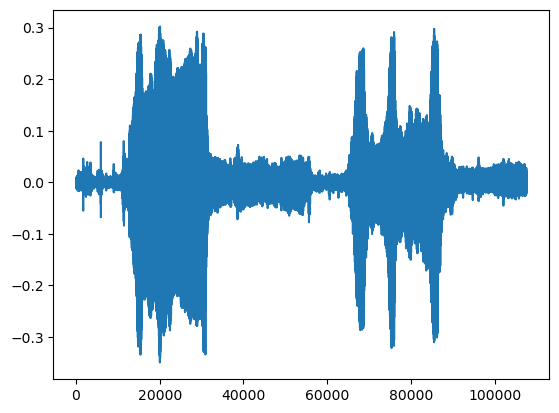

In [6]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

# Load class mappings

In [7]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

In [8]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

2024-02-17 12:25:49.061945: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-17 12:25:49.633435: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-17 12:25:49.738915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


The main sound is: Animal
The embeddings shape: (13, 1024)


2024-02-17 12:25:50.061126: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-02-17 12:25:50.081713: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


# Load datasets

In [9]:
"""
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)
"""
!pwd

/data/GDSC_AudioPoli/AudioPoli-AI


In [29]:
base_train_dir = "/data/GDSC_AudioPoli/testset/Training/label/"
base_valid_dir = "/data/GDSC_AudioPoli/testset/Validation/label/"
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'

train_json_files = glob.glob(os.path.join(base_train_dir, '*/*.json'))
valid_json_files = glob.glob(os.path.join(base_valid_dir, '*/*.json'))
train_orig_files = glob.glob(os.path.join(base_train_audio, '*/*.wav'), recursive=True)
valid_orig_files = glob.glob(os.path.join(base_valid_audio, '*/*.wav'), recursive=True)
# valid_orig_files = glob.glob(base_valid_audio + '**/*.wav', recursive=True)

# print(train_json_files, train_orig_files)

def process_json_file(json_file):
    target = re.split('[/._]', json_file)[-2]
    result = [file for file in train_orig_files \
              if "_{0}_".format(target) in file]
    result = result[0] if len(result) > 0 else None
    data = json.load(open(json_file))
    data = pd.json_normalize(data)
    annotations = data['annotations'][0]
    # print(annotations)
    data = []
    for annotation in annotations:
        item = {}
        item['filename'] = result
        item['target'] = target
        item['category'] = annotation['categories']['category_02']
        item['audio_type'] = annotation['audioType']
        data.append(item)

    # print("{0}\n{1}\n".format(json_file, result))
    # print("{0} {1}_{2}".format(target, re.split('[/.\[\]_]', result)[-4], re.split('[/._]', result)[-1]))
    return data


# print(len(training_json_files), len(validation_json_files))
# print(training_json_files[:5], validation_json_files[:5])


all_data = []
"""
for file in train_json_files:
# for file in valid_json_files:
    data = process_json_file(file)
    all_data.extend(data)

# Create a DataFrame from the collected data
df = pd.DataFrame(all_data)

# Write the DataFrame to a CSV file
df.to_csv('output.csv', index=False)
# df.to_csv('output_valid.csv', index=False)
"""

"\nfor file in train_json_files:\n# for file in valid_json_files:\n    data = process_json_file(file)\n    all_data.extend(data)\n\n# Create a DataFrame from the collected data\ndf = pd.DataFrame(all_data)\n\n# Write the DataFrame to a CSV file\ndf.to_csv('output.csv', index=False)\n# df.to_csv('output_valid.csv', index=False)\n"

In [11]:
print(len(all_data))
# df.head()

0


### Experiments (Don't run)

In [30]:
base_train_dir = "/data/GDSC_AudioPoli/testset/Training/label/"
base_valid_dir = "/data/GDSC_AudioPoli/testset/Validation/label/"
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'

train_json_files = glob.glob(os.path.join(base_train_dir, '*/*.json'))
valid_json_files = glob.glob(os.path.join(base_valid_dir, '*/*.json'))
train_orig_files = glob.glob(os.path.join(base_train_audio, '*/*.wav'), recursive=True)
valid_orig_files = glob.glob(os.path.join(base_valid_audio, '*/*.wav'), recursive=True)

json_file = "/data/GDSC_AudioPoli/testset/Validation/label/[라벨]8.전기사고/8.전기사고_236859.json"
target = re.split('[/._]', json_file)[-2]
result = [file for file in valid_orig_files \
          if "_{0}_".format(target) in file][0]
print(target, result)

236859 /data/GDSC_AudioPoli/testset/Validation/orig/[원천]8.전기사고_1/8.전기사고_236859_label.wav


In [ ]:
path = "/data/GDSC_AudioPoli/testset/Training/orig/"
tmp = "/data/GDSC_AudioPoli/testset/Training/label/[라벨]8.전기사고/8.전기사고_226549.json"
foo = "_{0}_".format(re.split('[/._]', tmp)[-2])
print(foo)

train_orig_list = glob.glob(path + '**/*.wav', recursive=True)
print(all_wav_files[:5])

result = [file for file in train_orig_list if foo in file]
print(result)

In [ ]:
path = "/data/GDSC_AudioPoli/testset/Training/orig/"
tmp = "/data/GDSC_AudioPoli/testset/Training/label/[라벨]8.전기사고/8.전기사고_226549.json"
foo = re.split('[/._]', tmp)[-2]
result = [filename for filename in glob.glob("{0}**/*_{1}_label.wav".format(path, foo), recursive=True)][0]
print(foo, result)

### Check

In [31]:
output_csv = '/data/GDSC_AudioPoli/AudioPoli-AI/output.csv'
output_valid_csv = '/data/GDSC_AudioPoli/AudioPoli-AI/output_valid.csv'
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'


pd_data = pd.read_csv(output_csv)
pd_data.head(10)

filename   target category  \
0  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   226549     전기사고   
1  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   220721     전기사고   
2  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   232239     전기사고   
3  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   234023     전기사고   
4  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   222619     전기사고   
5  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   168183     전기사고   
6  /data/GDSC_AudioPoli/testset/Training/orig/[원천...  1147795     전기사고   
7  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   155910     전기사고   
8  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   181836     전기사고   
9  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   234356     전기사고   

  audio_type  
0      voice  
1      voice  
2      voice  
3      voice  
4      voice  
5      voice  
6      voice  
7      voice  
8      voice  
9      voice

In [32]:
pd_data

filename   target category  \
0       /data/GDSC_AudioPoli/testset/Training/orig/[원천...   226549     전기사고   
1       /data/GDSC_AudioPoli/testset/Training/orig/[원천...   220721     전기사고   
2       /data/GDSC_AudioPoli/testset/Training/orig/[원천...   232239     전기사고   
3       /data/GDSC_AudioPoli/testset/Training/orig/[원천...   234023     전기사고   
4       /data/GDSC_AudioPoli/testset/Training/orig/[원천...   222619     전기사고   
...                                                   ...      ...      ...   
447060  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   594834     절도범죄   
447061  /data/GDSC_AudioPoli/testset/Training/orig/[원천...  1238090     절도범죄   
447062  /data/GDSC_AudioPoli/testset/Training/orig/[원천...  1238011     절도범죄   
447063  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   595821     절도범죄   
447064  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   282214     절도범죄   

       audio_type  
0           voice  
1           voice  
2           voice  
3           voice  
4           voice  
...           ...  
447060      voice  
447061      voice  
447062      voice  
447063      voice  
447064      voice  

[447065 rows x 4 columns]

### Drop columns with lost filenames

In [ ]:
# pd_data.to_csv('output_dropna.csv', index=False)

# Data Filtering

In [132]:
from sklearn import model_selection

output_dropna_csv = '/data/GDSC_AudioPoli/AudioPoli-AI/output_dropna.csv'
pd_data = pd.read_csv(output_dropna_csv)

my_classes = ['강제추행(성범죄)', '강도범죄', '절도범죄', '폭력범죄',
              '화재', '갇힘', '응급의료', '전기사고', '가스사고', '낙상', 
              '붕괴사고', '태풍-강풍', '지진', '도움요청', '실내', '실외'
             ]
map_class_to_id = {'강제추행(성범죄)':1, '강도범죄':2, '절도범죄':3, '폭력범죄':4,
              '화재':5, '갇힘':6, '응급의료':7, '전기사고':8, '가스사고':9, '낙상':10, 
              '붕괴사고':11, '태풍-강풍':12, '지진':13, '도움요청':14, '실내':15, '실외':16}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(category=class_id)

# KFold (n = 5)
filtered_pd['fold'] = -1
kf = model_selection.KFold(n_splits = 5)
for fold, (trn_, val_) in enumerate(kf.split(X=filtered_pd)):
    filtered_pd.loc[val_, 'fold'] = fold

# filtered_pd['Fold'].unique()
    
filtered_pd.head(10)

filename   target  category  \
0  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   226549         8   
1  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   220721         8   
2  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   232239         8   
3  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   234023         8   
4  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   222619         8   
5  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   168183         8   
6  /data/GDSC_AudioPoli/testset/Training/orig/[원천...  1147795         8   
7  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   155910         8   
8  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   181836         8   
9  /data/GDSC_AudioPoli/testset/Training/orig/[원천...   234356         8   

  audio_type  fold  
0      voice     0  
1      voice     0  
2      voice     0  
3      voice     0  
4      voice     0  
5      voice     0  
6      voice     0  
7      voice     0  
8      voice     0  
9      voice     0

# Audio file embeddings

In [34]:
filenames = filtered_pd['filename']
targets = filtered_pd['category']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [35]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [36]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

# K-Fold


In [37]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Model for embeddings

In [38]:
from tensorflow.keras import layers, models

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

"""
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,  3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2,  2)),
    
    layers.Conv2D(64, kernel_size=(3,  3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,  2)),
    
    layers.Conv2D(128, kernel_size=(3,  3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,  2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
"""

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 16)                8208      
                                                                 
Total params: 533008 (2.03 MB)
Trainable params: 533008 (2.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [40]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20


2024-02-17 12:31:58.052700: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.052791: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.052836: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.052921: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.053066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18418682533081400154
2024-02-17 12:31:58.053103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item ca

InvalidArgumentError: Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
<stack traces unavailable>
Detected at node DecodeWav defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_18516]

2024-02-17 12:31:58.188422: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.196593: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.196869: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.207531: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.208479: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 12:31:58.208820: W tensorflow/core/framework/op_kernel.cc:1839] 

In [ ]:
# Check for overfittings

loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

### Check with wav metadata

In [144]:
num_channels = []
file_name = []
for wav_file in filtered_pd['filename']:
    file = open(wav_file, 'rb')
    l1 = file.readline()
    num_channels.append(l1[20:22])
    file_name.append(wav_file)

In [136]:
for i in range(len(num_channels)):
    if num_channels[i][8:12] != b'WAVE':
        print('File name : {0}'.format(file_name[i]))
        print('Chunk ID : {0}'.format(num_channels[i][0:4]))
        print('Chunk Size : {0}'.format(num_channels[i][4:8]))
        print('Format : {0}'.format(num_channels[i][8:12]))
        print('Chunk ID : {0}'.format(num_channels[i][12:16]))
        print('Chunk Size : {0}'.format(num_channels[i][16:20]))
        print('Audio Format : {0}'.format(num_channels[i][20:22]))
        print('Channel number : {0}'.format(num_channels[i][22:24]))
        print("----------------------------------------")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]1.강제추행(성범죄)_1/1.강제추행(성범죄)_132736_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\xbe\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
Audio Format : b''
Channel number : b''
----------------------------------------
File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]1.강제추행(성범죄)_1/1.강제추행(성범죄)_1247479_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'd\xc4\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
Audio Format : b''
Channel number : b''
----------------------------------------
File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]1.강제추행(성범죄)_1/1.강제추행(성범죄)_145026_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
Audio Format : b''
Channel number : b''
----------------------------------------
File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]1.강제추행(성범죄)_1/1.강제추행(성범죄)_1229922_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\x1cK\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
A

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [145]:
from collections import Counter
Counter(num_channels)

Counter({b'\x01\x00': 407454, b'': 34065})

In [143]:
# "/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav"
# "/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_502855_label.wav"
# "/data/GDSC_AudioPoli/testset/Training/orig/[원천]14.도움요청_1/14.도움요청_757631_label.wav"



tmp = "/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav"
print('File name : {0}'.format(tmp))
foo = open(tmp, 'rb')
bar = foo.readline()
print('Chunk ID : {0}'.format(bar[0:4]))
print('Chunk Size : {0}'.format(bar[4:8]))
print('Format : {0}'.format(bar[8:12]))
print('Chunk ID : {0}'.format(bar[12:16]))
print('Chunk Size : {0}'.format(bar[16:20]))
print('Audio Format : {0}'.format(bar[20:22]))
print('Channel number : {0}'.format(bar[22:24]))
print("----------------------------------------")

File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\xe4\xf2\x1c\x00'
Format : b'WAVE'
Chunk ID : b'fmt '
Chunk Size : b'\x10\x00\x00\x00'
Audio Format : b'\x01\x00'
Channel number : b'\x02\x00'
----------------------------------------


### Check whether problem due to float32 encoding

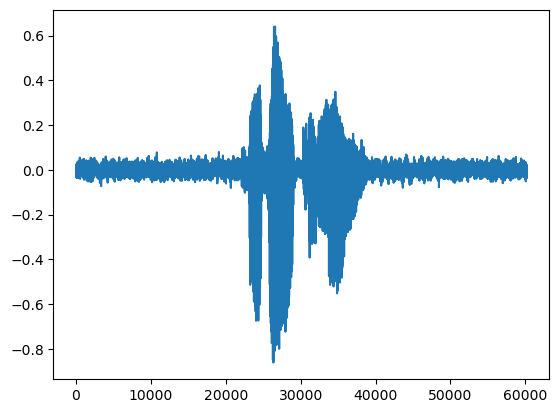

In [140]:
# Failed to load
# tmp = load_wav_16k_mono("/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav")

# Succeeded to load
# tmp = load_wav_16k_mono("/data/GDSC_AudioPoli/testset/Training/orig/[원천]5.화재_1/5.화재_1033548_label.wav")
tmp = load_wav_16k_mono("/data/GDSC_AudioPoli/testset/Training/orig/[원천]1.강제추행(성범죄)_1/1.강제추행(성범죄)_1236427_label.wav")
_ = plt.plot(tmp)

# Play the audio file.
display.Audio(tmp, rate=16000)

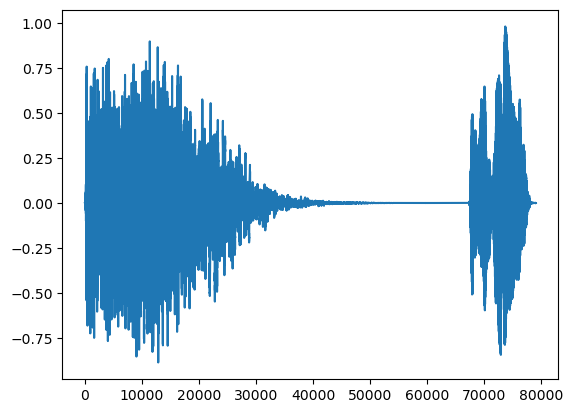

In [142]:
input_file = '/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_501776_label.wav'
output_file = './output.wav'

data, samplerate = sf.read(input_file)
sf.write(output_file, data, samplerate, subtype='PCM_16')


# tmp = load_wav_16k_mono(input_file)
tmp = load_wav_16k_mono(output_file)
_ = plt.plot(tmp)

# Play the audio file.
display.Audio(tmp, rate=16000)

### Convert float32 to int16

In [ ]:
num_channels = []
file_name = []
for wav_file in filtered_pd['filename']:
    try:
        _ = load_wav_16k_mono(wav_file)
    except Exception as e:
        print(e)
        data, samplerate = sf.read(wav_file)
        sf.write(wav_file, data, samplerate, subtype='PCM_16')

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:09.016070: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:09.016096: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:09.016102: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:09.016106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:09.016112: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:09.016116: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10821080551487378655
2024-02-17 14:00:09.016121: I tensorflow/core/framework/local_rendezv

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:09.398339: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:09.399420: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:09.399436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:09.399441: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:09.399446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:09.399451: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:09.399462: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:09.668672: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:09.669418: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:09.669434: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:09.669439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:09.669444: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:09.669448: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:09.788955: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:09.790540: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:09.790555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:09.790561: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:09.790565: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:09.790571: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:09.790575: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:10.008329: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.009528: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.009544: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:10.009551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:10.009556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:10.009566: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:10.009571: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:10.122878: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.123250: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.123263: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:10.123270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:10.123275: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:10.123280: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755
2024-02-17 14:00:10.200731: W tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:10.407226: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.409421: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.409437: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:10.409443: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:10.409447: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:10.409454: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:10.409458: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:10.525743: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.526077: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.526092: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:10.526098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:10.526103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:10.526108: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:10.634396: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.635468: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.635483: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:10.635490: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:10.635495: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:10.635500: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:10.753844: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.754388: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.754404: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:10.754412: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:10.754417: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:10.754422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755
2024-02-17 14:00:10.820397: W tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:10.989624: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.990333: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:10.990353: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:10.990359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:10.990363: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:10.990368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:11.075312: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.075712: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.075733: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.075741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:11.075749: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:11.075758: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:11.142968: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.143838: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.143860: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.143889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:11.143898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:11.143912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10821080551487378655
2024-02-17 14:00:11.143919: I te

2024-02-17 14:00:11.255081: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.257472: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.257488: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.257494: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:11.257498: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:11.257505: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:11.257509: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:11.332853: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.334557: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.334572: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.334578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:11.334583: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:11.334589: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:11.334593: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:11.451705: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.453915: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.453931: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.453936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:11.453941: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:11.453948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:11.453952: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:11.651547: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.652596: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.652610: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.652615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:11.652628: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10821080551487378655
2024-02-17 14:00:11.652635: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755
2024-02-17 14:00:11.652642: I t

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:11.768127: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.769495: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.769510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.769514: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:11.769518: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:11.769523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:11.769526: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:11.983572: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.984640: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:11.984656: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:11.984662: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:11.984668: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:11.984673: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:12.214426: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.215728: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.215744: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:12.215749: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:12.215753: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:12.215759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:12.215762: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:12.329462: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.330528: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.330543: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:12.330548: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:12.330552: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:12.330556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:12.450451: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.450873: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.450893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:12.450900: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:12.450906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:12.450913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:12.567789: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.568837: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.568854: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:12.568860: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:12.568865: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:12.568870: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:12.687126: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.687872: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.687888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:12.687894: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:12.687899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:12.687903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:12.904350: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.905674: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:12.905696: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:12.905703: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:12.905709: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:12.905718: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:12.905723: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.126090: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.126713: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.126734: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.126743: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.126751: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.126759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.240626: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.242146: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.242162: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.242168: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.242173: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.242180: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:13.242185: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.369919: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.370534: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.370550: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.370557: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.370563: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.370569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.496968: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.497550: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.497565: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.497569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.497574: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.497578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.629314: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.629851: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.629865: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.629870: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.629874: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.629878: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.745822: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.746193: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.746211: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.746219: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.746225: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.746231: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.854146: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.855506: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.855520: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.855524: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.855528: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.855534: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:13.855537: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:13.974286: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.975405: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:13.975423: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:13.975431: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:13.975436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:13.975442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:14.107470: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.108476: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.108495: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:14.108502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:14.108509: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:14.108516: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:14.225007: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.225875: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.225901: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:14.225908: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:14.225914: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:14.225920: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:14.346544: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.347661: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.347676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:14.347683: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:14.347688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:14.347696: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:14.347702: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:14.461035: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.461994: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.462009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:14.462014: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:14.462018: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:14.462022: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:14.582246: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.583139: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.583154: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:14.583160: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:14.583165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:14.583170: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:14.697024: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.697634: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.697650: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:14.697657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:14.697662: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:14.697668: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:14.922154: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.923453: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:14.923470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:14.923475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:14.923480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:14.923486: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:14.923491: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:15.495084: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:15.496053: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:15.496068: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:15.496073: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:15.496077: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:15.496081: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:15.617709: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:15.618342: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:15.618362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:15.618369: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:15.618375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:15.618380: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755
2024-02-17 14:00:15.760993: W tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:15.891482: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:15.892600: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:15.892616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:15.892622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:15.892627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:15.892632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:16.012534: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.013015: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.013034: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:16.013040: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:16.013046: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:16.013052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:16.379420: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.380245: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.380260: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:16.380264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:16.380269: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:16.380273: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:16.499941: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.500755: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.500774: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:16.500781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:16.500787: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:16.500792: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:16.632467: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.633989: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.634005: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:16.634012: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:16.634018: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:16.634024: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:16.941901: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.942890: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:16.942905: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:16.942913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:16.942919: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 14446915913029494288
2024-02-17 14:00:16.942924: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:16.942931: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:17.261814: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.262743: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.262760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:17.262766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:17.262771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:17.262776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:17.377029: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.377947: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.377967: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:17.377973: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:17.377979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:17.377985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:17.495710: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.496549: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.496564: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:17.496604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:17.496609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:17.496613: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:17.613741: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.614588: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.614603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:17.614608: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:17.614612: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:17.614616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:17.738256: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.739235: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.739251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:17.739256: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:17.739260: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:17.739268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:17.739271: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:17.856308: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.858761: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.858776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:17.858782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:17.858787: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:17.858793: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:17.858798: I tens

2024-02-17 14:00:17.982292: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.982903: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:17.982921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:17.982928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:17.982934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:17.982939: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:18.103918: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.104467: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.104485: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:18.104491: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:18.104496: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:18.104500: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:18.218711: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.219570: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.219590: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:18.219597: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:18.219604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:18.219609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:18.858401: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.860646: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.860661: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:18.860666: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:18.860670: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:18.860676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:18.860679: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:18.978753: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.979914: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:18.979935: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:18.979943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:18.979949: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:18.979955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:19.315854: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.316652: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.316667: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:19.316672: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:19.316676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:19.316681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:19.436651: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.437382: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.437397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:19.437402: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:19.437406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:19.437413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:19.558034: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.559014: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.559032: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:19.559039: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:19.559046: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:19.559063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:19.559070: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:19.679639: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.680702: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.680716: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:19.680722: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:19.680726: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:19.680730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:19.800145: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.800788: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:19.800811: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:19.800818: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:19.800823: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:19.800828: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:20.027292: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:20.028411: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:20.028425: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:20.028430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:20.028434: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:20.028440: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:20.028443: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:20.482139: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:20.483015: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:20.483031: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:20.483039: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:20.483044: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:20.483049: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:20.703387: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:20.704319: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:20.704339: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:20.704346: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:20.704352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:20.704357: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:21.132159: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.133441: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.133456: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:21.133461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:21.133468: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:21.133473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:21.359894: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.360914: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.360928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:21.360933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:21.360937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:21.360944: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:21.360948: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:21.496270: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.497618: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.497632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:21.497637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:21.497641: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:21.497647: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:21.497652: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:21.618093: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.618858: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.618876: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:21.618883: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:21.618889: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:21.618895: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:21.952584: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.953518: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:21.953533: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:21.953538: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:21.953542: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:21.953546: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:22.176741: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.177258: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.177272: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:22.177277: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:22.177282: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:22.177286: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:22.301398: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.302267: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.302281: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:22.302288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:22.302293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:22.302298: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:22.424818: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.425337: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.425354: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:22.425360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:22.425366: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:22.425379: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:22.551051: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.551981: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.551997: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:22.552004: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:22.552010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:22.552015: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:22.680330: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.680928: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:22.680944: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:22.680950: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:22.680955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:22.680960: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:23.025669: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.026965: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.026980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:23.026985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:23.026988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:23.026994: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:23.026998: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:23.265029: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.265736: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.265750: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:23.265755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:23.265760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:23.265763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:23.382100: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.382759: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.382773: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:23.382778: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:23.382782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:23.382786: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:23.596495: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.597281: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.597297: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:23.597302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:23.597306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:23.597309: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:23.714148: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.715336: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.715350: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:23.715355: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:23.715359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:23.715363: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:23.825631: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.826205: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.826224: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:23.826231: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:23.826239: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:23.826246: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:23.944549: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.945271: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:23.945291: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:23.945300: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:23.945307: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:23.945315: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:24.069839: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.070821: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.070841: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:24.070851: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:24.070858: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:24.070866: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:24.295697: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.296300: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.296333: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:24.296338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:24.296342: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:24.296346: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:24.412375: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.413035: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.413055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:24.413062: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:24.413069: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:24.413075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:24.528034: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.528914: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.528930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:24.528972: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:24.528981: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:24.528992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:24.649005: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.649608: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.649639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:24.649649: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:24.649657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:24.649665: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:24.766712: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.767724: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.767738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:24.767743: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:24.767748: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:24.767751: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:24.889047: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.889604: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:24.889623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:24.889630: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:24.889636: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:24.889642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.007062: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.007742: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.007758: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.007763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.007767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.007771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.121961: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.122426: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.122449: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.122456: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.122461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.122467: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.246641: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.247565: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.247580: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.247586: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.247590: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.247594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.365813: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.366867: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.366882: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.366886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.366890: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.366894: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.495782: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.498290: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.498308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.498314: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.498319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.498325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:25.498329: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.617630: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.618408: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.618427: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.618434: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.618440: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.618445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.737919: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.738878: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.738898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.738906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.738912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.738918: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.865107: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.865959: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.865974: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.865979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.865983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.865987: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:25.986046: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.987027: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:25.987042: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:25.987046: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:25.987051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:25.987054: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:26.209082: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:26.209919: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:26.209933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:26.209939: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:26.209944: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:26.209950: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:26.209964: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:26.432449: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:26.432992: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:26.433016: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:26.433027: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:26.433036: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:26.433045: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:26.762562: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:26.763546: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:26.763562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:26.763568: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:26.763572: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:26.763576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:27.088434: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.089453: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.089469: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:27.089476: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:27.089481: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:27.089487: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:27.205741: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.206418: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.206439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:27.206449: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:27.206457: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:27.206465: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:27.328053: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.328658: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.328679: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:27.328689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:27.328696: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:27.328704: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:27.443210: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.443784: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.443802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:27.443809: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:27.443815: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:27.443821: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:27.665054: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.665853: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.665869: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:27.665875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:27.665881: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:27.665886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:27.906624: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.907522: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:27.907539: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:27.907545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:27.907549: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:27.907555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10821080551487378655
2024-02-17 14:00:27.907560: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:28.032398: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.033281: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.033298: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:28.033304: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:28.033310: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:28.033315: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:28.159849: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.160920: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.160937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:28.161004: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:28.161010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:28.161015: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:28.609256: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.610042: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.610058: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:28.610064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:28.610070: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:28.610075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:28.827245: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.827820: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.827841: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:28.827848: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:28.827855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:28.827863: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:28.951741: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.954295: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:28.954309: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:28.954315: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:28.954318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:28.954325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:28.954328: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:29.077088: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.078320: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.078337: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:29.078343: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:29.078349: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:29.078354: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:29.200880: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.201869: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.201885: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:29.201890: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:29.201894: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:29.201898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:29.498747: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.499243: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.499263: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:29.499273: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:29.499280: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:29.499288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:29.710501: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.711961: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.711977: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:29.711983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:29.711988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:29.711996: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:29.712001: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:29.835971: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.837391: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.837408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:29.837414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:29.837420: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:29.837426: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:29.957174: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.958278: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:29.958294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:29.958300: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:29.958306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:29.958311: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:30.084030: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.084766: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.084781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:30.084786: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:30.084791: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:30.084796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:30.391041: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.392039: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.392054: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:30.392061: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:30.392066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:30.392073: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:30.514209: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.515226: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.515244: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:30.515251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:30.515255: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:30.515260: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:30.713368: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.715039: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.715053: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:30.715059: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:30.715064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:30.715072: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:30.715077: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:30.835476: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.836172: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.836188: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:30.836195: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:30.836200: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:30.836205: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:30.961260: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.962202: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:30.962217: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:30.962224: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:30.962229: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:30.962234: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:31.209046: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.209856: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.209871: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:31.209875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:31.209880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:31.209883: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:31.431533: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.432097: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.432114: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:31.432121: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:31.432126: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:31.432132: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:31.555562: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.556691: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.556706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:31.556710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:31.556714: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:31.556719: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:31.556723: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:31.675639: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.676393: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.676414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:31.676421: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:31.676429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:31.676496: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:31.794131: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.794594: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.794613: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:31.794653: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:31.794660: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:31.794666: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:31.919442: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.920476: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:31.920497: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:31.920502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:31.920506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:31.920511: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:31.920514: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:32.201459: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:32.202381: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:32.202396: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:32.202401: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:32.202406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:32.202410: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:33.198685: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.199837: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.199851: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:33.199856: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:33.199859: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:33.199865: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:33.199868: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:33.317762: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.318739: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.318756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:33.318763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:33.318768: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:33.318844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:33.447522: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.448177: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.448192: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:33.448268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:33.448275: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:33.448280: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:33.562830: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.563362: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.563378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:33.563385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:33.563417: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:33.563422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:33.680598: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.681134: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.681153: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:33.681161: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:33.681166: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:33.681172: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:33.812296: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.813544: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.813558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:33.813563: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:33.813568: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:33.813575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:33.813594: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:33.936575: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.937448: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:33.937464: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:33.937471: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:33.937476: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:33.937481: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.053726: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.054145: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.054175: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.054182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.054188: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.054194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.272008: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.272527: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.272544: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.272551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.272557: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.272562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.396246: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.397268: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.397288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.397294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.397299: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.397306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:34.397311: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.512073: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.513545: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.513558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.513563: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.513567: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.513572: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:34.513576: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.636373: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.638037: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.638051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.638056: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.638059: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.638065: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:34.638068: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.754568: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.755752: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.755766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.755771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.755775: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.755779: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.877177: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.877737: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.877752: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.877757: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.877762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.877766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:34.993409: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.993998: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:34.994025: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:34.994032: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:34.994036: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:34.994040: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:35.219438: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.219953: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.219969: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:35.219976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:35.219982: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:35.219988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:35.347349: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.348016: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.348043: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:35.348050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:35.348055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:35.348061: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:35.473870: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.474373: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.474392: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:35.474400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:35.474405: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:35.474411: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:35.602355: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.603975: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.603988: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:35.603993: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:35.603997: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:35.604002: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:35.604006: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:35.723296: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.723867: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.723904: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:35.723980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:35.723987: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:35.723992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:35.844568: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.845886: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.845900: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:35.845905: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:35.845909: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:35.845915: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:35.845918: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:35.969435: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.970082: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:35.970098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:35.970104: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:35.970109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:35.970113: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:36.085118: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.085391: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.085406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:36.085413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:36.085419: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:36.085425: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:36.303253: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.304074: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.304092: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:36.304099: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:36.304105: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:36.304111: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:36.418416: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.419152: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.419171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:36.419179: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:36.419187: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:36.419195: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:36.542993: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.545345: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.545361: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:36.545367: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:36.545371: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:36.545377: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:36.545382: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:36.866858: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.867682: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:36.867698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:36.867703: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:36.867707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:36.867712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:37.084787: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.085818: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.085833: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:37.085838: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:37.085842: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:37.085847: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:37.202933: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.203748: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.203767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:37.203774: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:37.203780: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:37.203786: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:37.439968: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.441059: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.441074: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:37.441079: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:37.441082: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:37.441087: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:37.559052: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.560270: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.560283: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:37.560289: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:37.560293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:37.560297: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:37.683749: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.684784: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.684802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:37.684809: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:37.684816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:37.684821: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:37.803146: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.803808: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.803827: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:37.803834: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:37.803840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:37.803846: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:37.927427: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.928077: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:37.928095: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:37.928102: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:37.928108: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:37.928114: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:38.043839: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.044949: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.044963: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:38.044968: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:38.044972: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:38.044977: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:38.044980: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:38.165393: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.166062: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.166077: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:38.166082: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:38.166086: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:38.166090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:38.300867: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.302335: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.302351: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:38.302355: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:38.302359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:38.302365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:38.302368: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:38.415098: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.416267: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.416286: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:38.416293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:38.416299: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:38.416306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:38.703874: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.704945: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.704969: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:38.704975: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:38.704981: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:38.704985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:38.820161: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.821415: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.821431: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:38.821437: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:38.821441: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:38.821444: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:38.936673: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.937515: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:38.937533: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:38.937540: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:38.937547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:38.937553: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:39.068214: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.069305: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.069320: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:39.069325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:39.069329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:39.069333: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:39.182708: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.183465: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.183484: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:39.183492: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:39.183569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:39.183576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:39.299558: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.300590: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.300608: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:39.300615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:39.300622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:39.300628: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:39.425340: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.426121: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.426140: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:39.426147: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:39.426153: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:39.426158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:39.903381: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.904548: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:39.904562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:39.904567: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:39.904570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:39.904576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:39.904580: I tens

2024-02-17 14:00:40.078542: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:40.079871: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:40.079886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:40.079892: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:40.079897: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:40.079903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:40.079906: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:40.587698: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:40.588327: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:40.588347: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:40.588354: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:40.588360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:40.588365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:40.713849: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:40.715345: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:40.715359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:40.715364: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:40.715368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:40.715373: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:40.715377: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:41.043086: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.044274: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.044296: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.044305: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.044313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.044319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:41.170770: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.171562: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.171580: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.171587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.171594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.171602: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:41.292278: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.293398: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.293413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.293418: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.293422: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.293425: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:41.411136: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.411820: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.411839: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.411846: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.411852: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.411858: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:41.535806: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.536340: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.536360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.536368: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.536374: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.536380: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:41.668740: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.669589: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.669603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.669608: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.669671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.669676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:41.809357: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.810165: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.810180: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.810186: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.810190: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.810194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:41.931445: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.932750: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:41.932765: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:41.932770: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:41.932774: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:41.932780: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:41.932784: I tens

2024-02-17 14:00:42.058603: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.059637: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.059651: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.059656: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:42.059660: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:42.059664: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:42.180821: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.181778: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.181792: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.181797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:42.181801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:42.181805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:42.300822: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.301159: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.301173: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.301178: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:42.301182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:42.301186: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:42.415076: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.416312: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.416326: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.416332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:42.416336: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:42.416340: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:42.535393: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.536593: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.536609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.536615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:42.536621: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:42.536639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:42.648559: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.649147: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.649166: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.649173: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:42.649179: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:42.649184: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:42.773050: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.774639: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.774652: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.774657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:42.774661: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:42.774667: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:42.774670: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:42.993661: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.994561: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:42.994576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:42.994584: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:42.994596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10821080551487378655
2024-02-17 14:00:42.994601: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755
2024-02-17 14:00:42.994607: I t

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:43.116934: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.117962: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.117976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:43.117981: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:43.117985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:43.117989: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


2024-02-17 14:00:43.246002: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.246872: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.246888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:43.246893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:43.246897: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:43.246903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17601545944708838553
2024-02-17 14:00:43.246920: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:43.340758: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.341155: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.341175: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:43.341183: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:43.341189: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:43.341195: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755
2024-02-17 14:00:43.441866: W tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:43.559053: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.559570: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.559583: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:43.559588: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:43.559592: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:43.559596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:43.680993: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.681563: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.681577: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:43.681582: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:43.681586: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:43.681590: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:43.809340: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.810307: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:43.810323: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:43.810330: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:43.810335: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:43.810341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:44.021038: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.021759: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.021777: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:44.021784: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:44.021790: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:44.021795: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:44.132595: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.133597: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.133611: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:44.133616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:44.133620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:44.133625: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:44.133629: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:44.355147: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.355893: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.355908: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:44.355914: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:44.355919: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:44.355952: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:44.473880: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.475397: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.475413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:44.475419: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:44.475425: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:44.475430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:44.594064: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.594601: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.594616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:44.594621: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:44.594627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:44.594632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:44.918365: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.919996: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:44.920012: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:44.920018: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:44.920023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:44.920029: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:44.920033: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:45.045758: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.046263: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.046282: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:45.046289: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:45.046295: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:45.046300: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:45.374024: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.374500: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.374513: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:45.374518: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:45.374522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:45.374526: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:45.505412: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.505938: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.505952: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:45.505957: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:45.505962: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:45.505965: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:45.626610: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.628427: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.628440: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:45.628445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:45.628448: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:45.628453: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:45.628456: I tens

2024-02-17 14:00:45.818829: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.819600: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.819618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:45.819624: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:45.819630: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:45.819635: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:45.941307: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.942371: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:45.942385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:45.942390: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:45.942394: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:45.942398: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:46.061122: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.061568: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.061588: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:46.061595: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:46.061600: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:46.061606: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:46.486363: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.487168: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.487182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:46.487189: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:46.487194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:46.487199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:46.618333: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.618959: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.618978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:46.618985: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:46.618991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:46.618997: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:46.743678: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.744689: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:46.744703: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:46.744708: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:46.744712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:46.744716: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:47.243143: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.244446: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.244461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:47.244470: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:47.244475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:47.244490: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10821080551487378655
2024-02-17 14:00:47.244503: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:47.667304: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.668064: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.668082: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:47.668091: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:47.668098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:47.668106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:47.781690: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.782560: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.782575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:47.782581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:47.782587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:47.782592: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:47.896811: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.897361: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:47.897378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:47.897385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:47.897391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:47.897396: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.021458: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.022655: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.022676: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.022684: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.022691: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:48.022697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.142931: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.144377: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.144392: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.144397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.144401: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:48.144407: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:48.144410: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.259438: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.260369: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.260382: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.260387: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10821080551487378655
2024-02-17 14:00:48.260400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755
2024-02-17 14:00:48.260407: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.260411: I te

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.383270: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.384036: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.384051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.384056: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.384060: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:48.384064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.516895: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.517371: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.517385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.517391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.517395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:48.517399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.641247: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.641793: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.641808: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.641813: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.641817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:48.641821: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.763862: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.764739: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.764755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.764762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.764767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:48.764773: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:48.993754: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.994805: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:48.994819: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:48.994824: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:48.994828: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:48.994832: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:49.569826: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:49.572105: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:49.572121: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:49.572127: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:49.572132: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:49.572139: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:49.572143: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:49.975081: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:49.976055: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:49.976071: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:49.976077: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:49.976081: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:49.976085: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:50.787346: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:50.787950: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:50.787971: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:50.787979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:50.787986: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:50.787992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:51.102236: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:51.102801: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:51.102817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:51.102823: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:51.102902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:51.102907: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:51.446767: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:51.447649: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:51.447665: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:51.447734: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:51.447740: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:51.447744: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:51.765130: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:51.765651: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:51.765667: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:51.765672: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:51.765677: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:51.765682: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:52.073180: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:52.073579: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:52.073594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:52.073600: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:52.073604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:52.073609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:52.508201: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:52.509078: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:52.509100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:52.509108: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:52.509115: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:52.509121: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:52.826574: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:52.827257: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:52.827272: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:52.827278: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:52.827282: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:52.827286: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:53.131558: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:53.132565: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:53.132580: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:53.132585: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:53.132590: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:53.132594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:53.456372: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:53.457383: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:53.457400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:53.457406: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:53.457411: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:53.457416: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:53.764615: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:53.765512: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:53.765527: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:53.765533: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:53.765537: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:53.765542: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:54.079197: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:54.079904: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:54.079921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:54.079927: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:54.079932: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:54.079936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:54.722209: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:54.723119: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:54.723136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:54.723142: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:54.723146: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:54.723150: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:55.078638: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:55.079591: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:55.079606: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:55.079611: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:55.079616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:55.079621: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:55.539122: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:55.540214: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:55.540243: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:55.540253: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:55.540261: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:55.540274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:55.540280: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:56.175598: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:56.177683: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:56.177699: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:56.177705: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:56.177709: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:56.177715: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:56.177719: I tens

Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:56.501668: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:56.502629: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:56.502650: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:56.502658: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:56.502664: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:56.502670: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:56.823278: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:56.823890: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:56.823906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:56.823912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:56.823916: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:56.823920: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:57.100830: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:57.101450: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:57.101473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:57.101478: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:57.101483: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:57.101487: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:57.420803: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:57.421187: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:57.421203: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:57.421208: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:57.421213: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:57.421217: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:57.866629: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:57.867714: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:57.867737: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:57.867747: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:57.867756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:57.867765: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:58.170864: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:58.171538: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:58.171554: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:58.171560: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:58.171565: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:58.171569: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11840682825950502755


Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 190

2024-02-17 14:00:58.596545: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:58.598920: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 14:00:58.598936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 14:00:58.598941: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 14:00:58.598945: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 14:00:58.598951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 14:00:58.598955: I tens

# Testing model


In [162]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 4]
# print(test_pd)
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
tmp = load_wav_16k_mono(filename)

/data/GDSC_AudioPoli/testset/Training/orig/[원천]9.가스사고_1/9.가스사고_685047_label.wav


2024-02-17 13:46:59.574695: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 13:46:59.587251: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-17 13:46:59.587270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4434035136214729894
2024-02-17 13:46:59.587276: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6507486112094432732
2024-02-17 13:46:59.587281: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 120709801255245766
2024-02-17 13:46:59.587288: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15898455528100930063
2024-02-17 13:46:59.587292: I tens

InvalidArgumentError: Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_435920/1003598801.py", line 6, in <module>

  File "/tmp/ipykernel_435920/2893689446.py", line 7, in load_wav_16k_mono

Detected at node DecodeWav defined at (most recent call last):
  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/jihwan/miniconda3/envs/AudioPoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_435920/1003598801.py", line 6, in <module>

  File "/tmp/ipykernel_435920/2893689446.py", line 7, in load_wav_16k_mono

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
	 [[loop_body/IO>AudioResample/pfor/while/body/_10/loop_body/IO>AudioResample/pfor/while/IO>AudioResample/_28]]
  (1) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_load_wav_16k_mono_54950]

In [93]:
# scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
scores, embeddings, spectrogram = yamnet_model(tmp)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: 낙상


### Pipelines for wave-input model

In [45]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [46]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


# Comparison with YAMNet models

/data/GDSC_AudioPoli/testset/Training/orig/[원천]14.도움요청_1/14.도움요청_793062_label.wav


Waveform values: [-1.9250681e-08  5.8154509e-08  8.3268205e-08 ...  5.1474422e-03
  3.3663702e-03  2.6304845e-03]


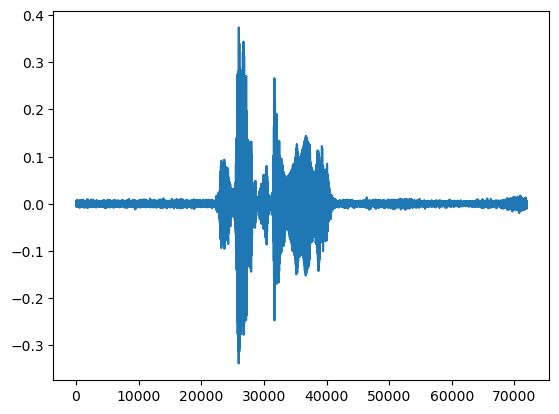

In [54]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 4]
# print(test_pd)
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [55]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

"""
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')
"""

[YAMNet] The main sound is: Speech (0.43215325474739075)


"\nreloaded_results = reloaded_model(waveform)\nyour_top_class = tf.math.argmax(reloaded_results)\nyour_inferred_class = my_classes[your_top_class]\nclass_probabilities = tf.nn.softmax(reloaded_results, axis=-1)\nyour_top_score = class_probabilities[your_top_class]\nprint(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')\n"